# Machine Learning
#### MIIA 4200 (2019-I) - Proyecto 2
## Movie Genre Classification

<p>Profesor:  Alejandro Correa Bahnsen</p>
<p>Estudiantes: Cristina Sierra Alcala - Oscar Andrés Mosquera - Eduardo Daniel Chain</p>

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview

### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

## Exploración preliminar de datos
#### Carga de los datos

- Se realiza la carga de los datos y la respectivas librerias

In [24]:
import pandas as pd
import os
import nltk
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.metrics import r2_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, svm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords  
import pickle

from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [9]:
#dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
#dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [25]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

- Explorar los campos y columnas de los dataframe

In [3]:
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [26]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [27]:
dataTraining2 = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTraining2.genres = dataTraining2.genres.str.split(',')
dataTraining2 = explode(dataTraining2, ['genres'])
dataTraining2.head()

,plot,rating,title,year,genres
0,major benson winifred payne is being discharge...,6.1,Major Payne,1995,['Adventure'
1,major benson winifred payne is being discharge...,6.1,Major Payne,1995,'Comedy'
2,major benson winifred payne is being discharge...,6.1,Major Payne,1995,'Family']
3,"in N ad , in the iron age , a spacecraft c...",6.3,Outlander,2008,['Action'
4,"in N ad , in the iron age , a spacecraft c...",6.3,Outlander,2008,'Adventure'


In [28]:
dataTraining2['genres'] = dataTraining2['genres'].str.replace('[','')
dataTraining2['genres'] = dataTraining2['genres'].str.replace(']','')
dataTraining2['genres'] = dataTraining2['genres'].str.replace("'",'')
dataTraining2['genres'] = dataTraining2['genres'].str.lstrip()

In [9]:
dataTraining2.head()

,plot,rating,title,year,genres
0,major benson winifred payne is being discharge...,6.1,Major Payne,1995,Adventure
1,major benson winifred payne is being discharge...,6.1,Major Payne,1995,Comedy
2,major benson winifred payne is being discharge...,6.1,Major Payne,1995,Family
3,"in N ad , in the iron age , a spacecraft c...",6.3,Outlander,2008,Action
4,"in N ad , in the iron age , a spacecraft c...",6.3,Outlander,2008,Adventure


## Visualización

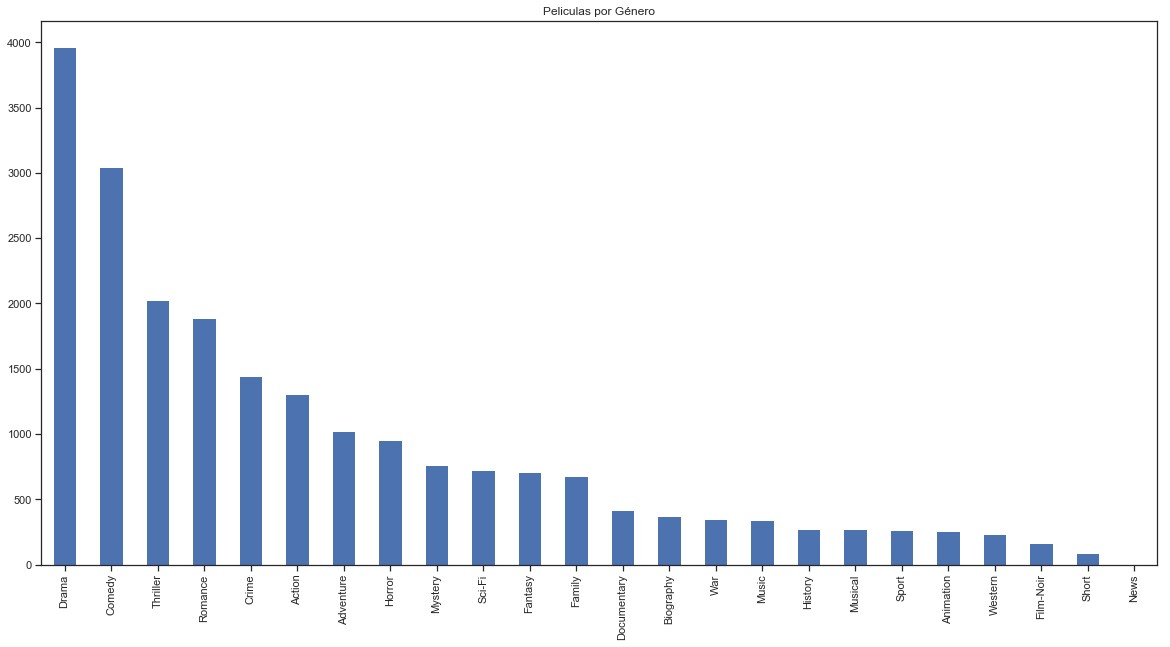

In [30]:
plt.figure(figsize=(20,10))
plot = dataTraining2['genres'].value_counts().plot(kind='bar', title='Peliculas por Género')

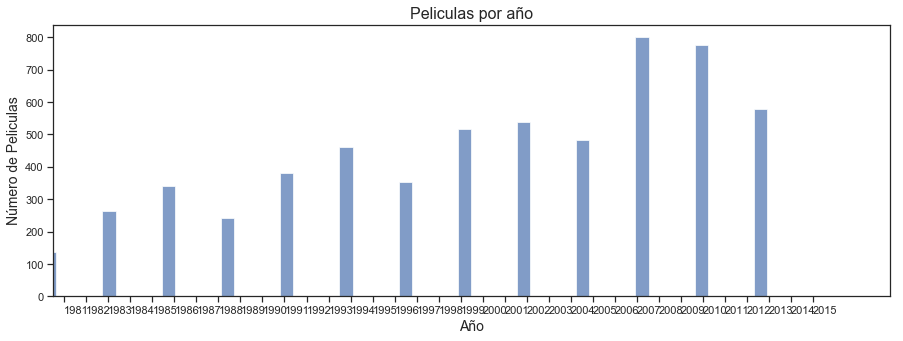

In [31]:
fig = plt.figure(figsize=(15,5))
ax = fig.gca()
sns.distplot(dataTraining.year,kde=False, hist_kws={"alpha":0.7,'width':0.6})
plt.title('Peliculas por año',fontsize=16)
plt.xticks(sorted(dataTraining.year.unique()),horizontalalignment='left')
plt.ylabel('Número de Peliculas',fontsize=14)
plt.xlabel('Año', fontsize=14)
plt.xlim(1980.5,2018.5)
plt.show()

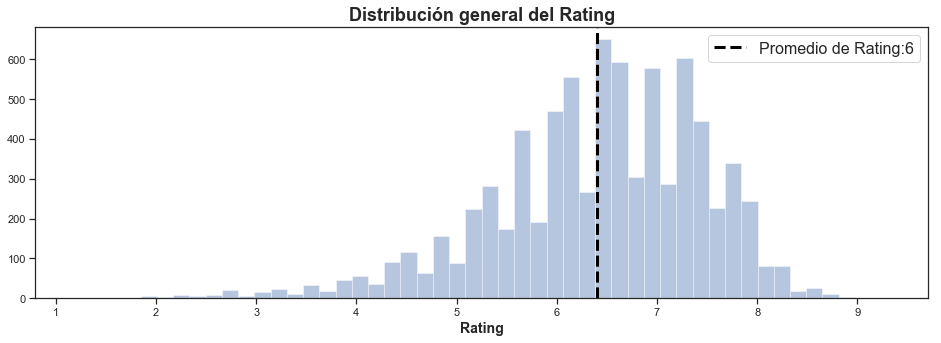

In [32]:
fig = plt.figure(figsize=(16,5))
ax = fig.gca()
sns.distplot(dataTraining.rating,kde=False)
plt.xlabel('Rating',fontsize=14,fontweight="bold")
plt.axvline(dataTraining.rating.mean(),lw=3,ls='dashed',
            color='black',label='Promedio de Rating:'+'{0:.0f}'.format(np.mean(dataTraining.rating)))
plt.title('Distribución general del Rating',fontsize=18,fontweight="bold")
plt.legend(loc='upper right',fontsize=16)
plt.show()

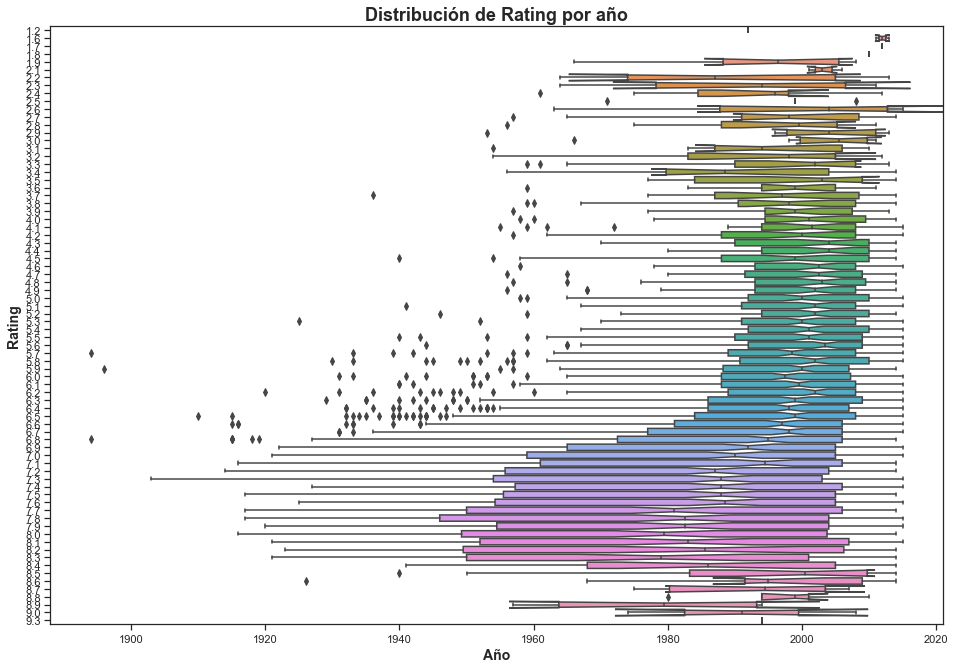

In [33]:
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='year',y='rating',data=dataTraining,notch=True,orient='h')
plt.xlabel('Año',fontsize=14,fontweight="bold")
ax.set_yticklabels(sorted(dataTraining.rating.unique()))
plt.ylabel('Rating',fontsize=14,fontweight="bold")
plt.title('Distribución de Rating por año',fontsize=18,fontweight="bold")

plt.show()

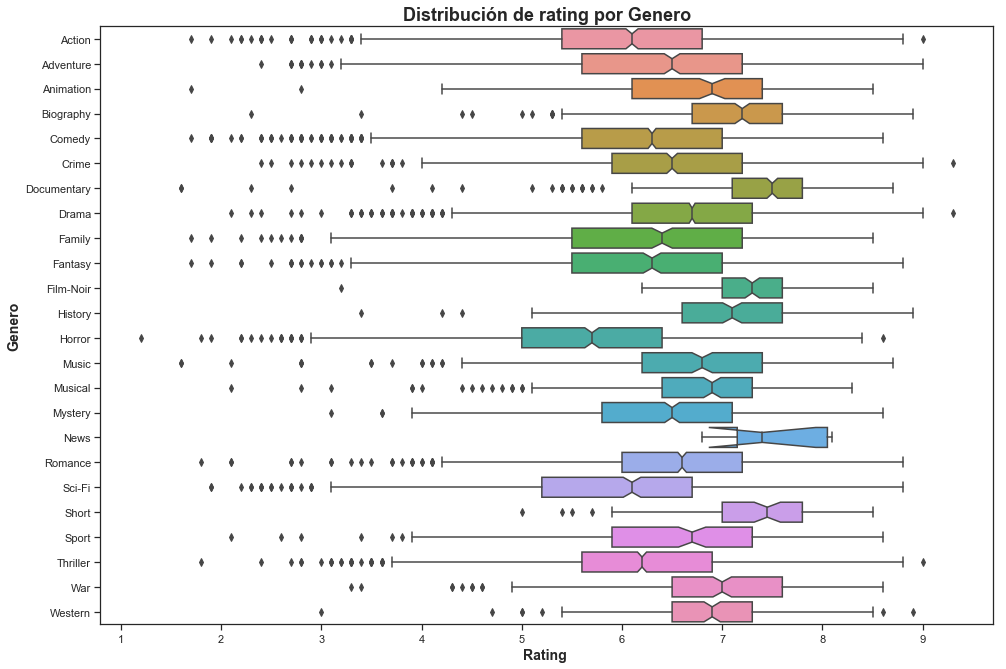

In [34]:
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='rating',y='genres',data=dataTraining2, order=sorted(dataTraining2.genres.unique()),notch=True,orient='h')
plt.xlabel('Rating ',fontsize=14,fontweight="bold")
plt.ylabel('Genero',fontsize=14,fontweight="bold")
plt.title('Distribución de rating por Genero',fontsize=18,fontweight="bold")
plt.show()

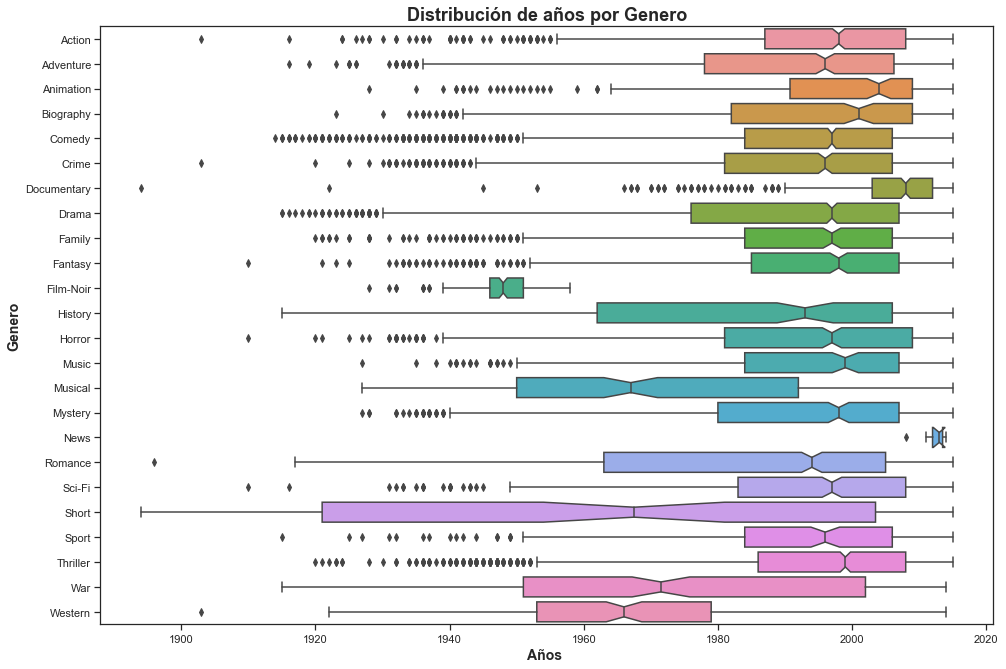

In [35]:
fig = plt.figure(figsize=(16,11))
ax = fig.gca()
sns.boxplot(x='year',y='genres',data=dataTraining2, order=sorted(dataTraining2.genres.unique()),notch=True,orient='h')
plt.xlabel('Años ',fontsize=14,fontweight="bold")
plt.ylabel('Genero',fontsize=14,fontweight="bold")
plt.title('Distribución de años por Genero',fontsize=18,fontweight="bold")
plt.show()

### Top words all genres

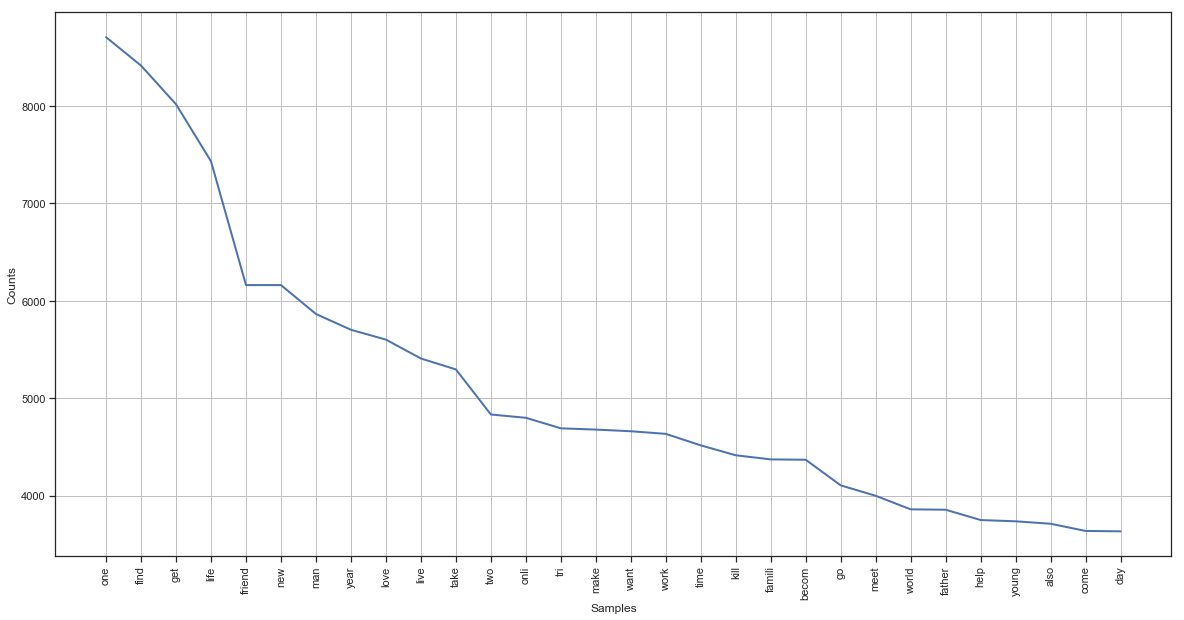

In [39]:
stemming =  SnowballStemmer("english")
df=dataTraining2.copy()
df['plot_title']=df['title']+' '+df['plot']
vals=" "
for ele in df['plot_title']:
    vals=ele+" "+vals
vals = vals.lower()  
vals = re.sub('[^a-zA-Z]', ' ', vals )  
vals = re.sub(r'\s+', ' ', vals) 
vals =' '.join([w for w in vals.split() if len(w)>1])
#vals =' '.join([wordnet_lemmatizer.lemmatize(i, pos="v") for i in vals.split()])
vals =' '.join([stemming.stem(i) for i in vals.split()])


tokens = [t for t in vals.split()]
 
stop_words = stopwords.words('english')
tokens = [word for word in tokens if word not in stop_words]
freq_1 = nltk.FreqDist(tokens)
plt.figure(figsize=(20,10))
freq_1.plot(30,cumulative=False)

In [18]:
comun_words=''
for f in range(50):
    comun_words=comun_words+' '+freq_1.most_common(50)[f][0]
comun_words = [t for t in comun_words.split()]

### Example top words genre Music

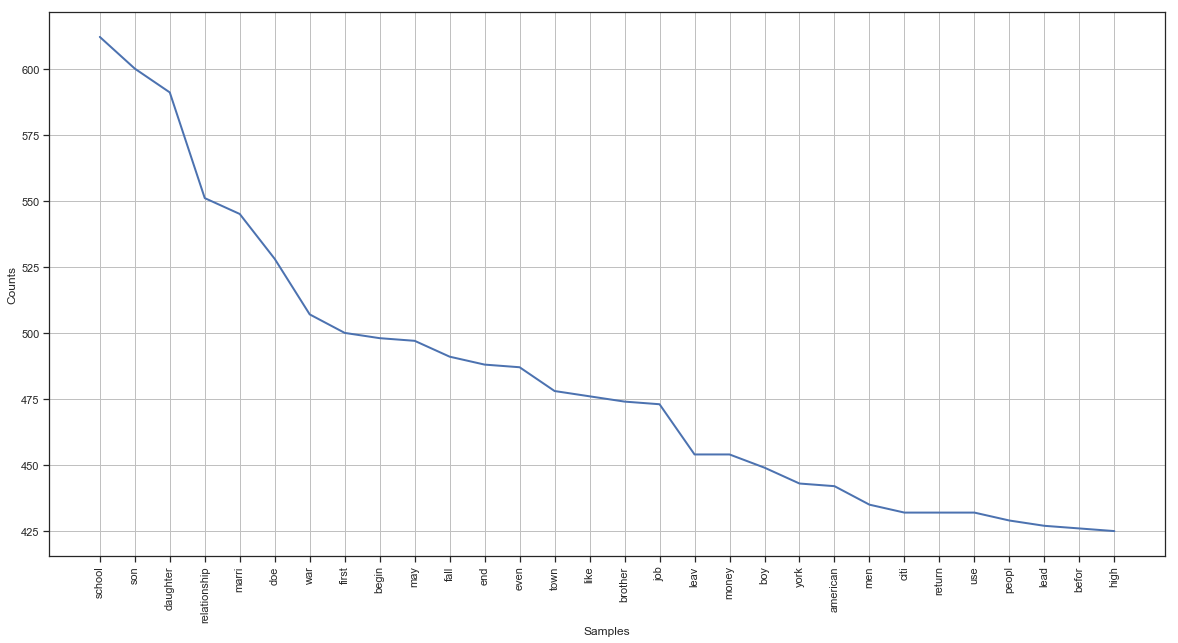

In [40]:
df=dataTraining2[dataTraining2['genres']=='Drama']
df['plot_title']=df['title']+' '+df['plot']
vals=" "
for ele in df['plot_title']:
    vals=ele+" "+vals
vals = vals.lower()  
vals = re.sub('[^a-zA-Z]', ' ', vals )  
vals = re.sub(r'\s+', ' ', vals) 
vals =' '.join([w for w in vals.split() if len(w)>1])
#vals =' '.join([wordnet_lemmatizer.lemmatize(i, pos="v") for i in vals.split()])
vals =' '.join([stemming.stem(i) for i in vals.split()])

tokens = [t for t in vals.split()]
 
stop_words = stopwords.words('english')
tokens = [word for word in tokens if word not in stop_words]
tokens = [word for word in tokens if word not in comun_words]
freq = nltk.FreqDist(tokens)
plt.figure(figsize=(20,10))
freq.plot(30,cumulative=False)

### Calculo top por genero excluyendo las comunes en toda la base

In [20]:
df_common=[]
for i in dataTraining2['genres'].unique():
    df=dataTraining2[dataTraining2['genres']==i]
    df['plot_title']=df['title']+' '+df['plot']
    vals=" "
    for ele in df['plot_title']:
        vals=ele+" "+vals
        
    vals = vals.lower()  
    vals = re.sub('[^a-zA-Z]', ' ', vals )  
    vals = re.sub(r'\s+', ' ', vals) 
    vals =' '.join([w for w in vals.split() if len(w)>1])
    #vals =' '.join([wordnet_lemmatizer.lemmatize(i, pos="v") for i in vals.split()])
    vals =' '.join([stemming.stem(i) for i in vals.split()])
    tokens = [t for t in vals.split()]
    stop_words = stopwords.words('english')
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in comun_words]
    freq = nltk.FreqDist(tokens)
    #freq.plot(30,cumulative=False)
    comun=' '
    for f in range(10):
        comun=comun+' '+freq.most_common(10)[f][0]
    comun = [t for t in comun.split()]
    df_common.append([i,comun])
    print (i,':   ',comun)
df_common=pd.DataFrame(df_common, columns=['genres','commun']) 

Adventure :    ['escap', 'must', 'son', 'power', 'earth', 'plan', 'king', 'return', 'befor', 'use']
Comedy :    ['school', 'like', 'marri', 'doe', 'fall', 'best', 'job', 'end', 'even', 'town']
Family :    ['boy', 'dog', 'littl', 'like', 'save', 'kid', 'school', 'must', 'son', 'adventur']
Action :    ['agent', 'forc', 'team', 'escap', 'must', 'fight', 'war', 'power', 'men', 'citi']
Sci-Fi :    ['earth', 'human', 'dr', 'alien', 'planet', 'discov', 'power', 'peopl', 'use', 'scientist']
Thriller :    ['polic', 'investig', 'soon', 'death', 'discov', 'dead', 'call', 'use', 'killer', 'agent']
Drama :    ['school', 'son', 'daughter', 'relationship', 'marri', 'doe', 'war', 'first', 'begin', 'may']
Biography :    ['film', 'war', 'boy', 'would', 'begin', 'first', 'american', 'death', 'includ', 'peopl']
History :    ['war', 'film', 'armi', 'american', 'king', 'men', 'fall', 'forc', 'lead', 'peopl']
Crime :    ['polic', 'investig', 'drug', 'money', 'case', 'crime', 'killer', 'detect', 'plan', 'pris

## Modelamiento

### Metodología

![Metodologia](https://github.com/amosqueraf/ML/raw/master/Metodologia_1.png)

![Metodologia](https://github.com/amosqueraf/ML/raw/master/Metodologia_4.png)

### Create count vectorizer


In [3]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(dataTraining['plot'])
#X_dtm = X_dtm.toarray()
X_dtm.shape

(7895, 38672)

In [56]:
print(vect.get_feature_names()[:50])

['aa', 'aaa', 'aames', 'aang', 'aaron', 'aaronow', 'aarons', 'aback', 'abagnale', 'abalam', 'abalone', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abatement', 'abba', 'abbe', 'abberline', 'abbey', 'abbie', 'abbott', 'abbotts', 'abby', 'abc', 'abdellatif', 'abdicate', 'abdomen', 'abduct', 'abducted', 'abductee', 'abducting', 'abduction', 'abductor', 'abductors', 'abducts', 'abdullah', 'abe', 'abel', 'abercrombie', 'aberline', 'abernathy', 'aberrant', 'aberration', 'abetting', 'abhor', 'abhorrent', 'abhorring', 'abhors']


### Create y

In [4]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [58]:
y_genres.shape

(7895, 24)

### Test-Train Split

- Para probar el rendimiento de los algoritmos, se divide el conjunto de datos en dos conjuntos distintos de train y test.

In [5]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=42)

In [60]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('y_train_genres shape:', y_train_genres.shape)
print('y_test_genres shape:', y_test_genres.shape)
label_num = len(y_train_genres[0])

X_train shape: (6316, 38672)
X_test shape: (1579, 38672)
y_train_genres shape: (6316, 24)
y_test_genres shape: (1579, 24)


### Train multi-class multi-label model

In [11]:
results = pd.DataFrame(columns=('Modelo','Técnica','roc_auc_score'))
results

,Modelo,Técnica,roc_auc_score


#### LogisticRegression with CountVectorizer

In [12]:
vect = CountVectorizer()
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm = X_dtm.toarray()

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=42)

In [ ]:
logreg = OneVsRestClassifier(LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

In [ ]:
y_pred_genres = logreg.predict_proba(X_test)

In [9]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8347085619945571

In [ ]:
results.loc[len(results)]=['LogisticRegression','CountVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

#### LogisticRegression with TfidfVectorizer

In [14]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [15]:
#tf_vect = TfidfVectorizer(min_df=2, tokenizer=None, preprocessor=None, stop_words=None)

tf_vect = TfidfVectorizer(min_df=2, max_df=0.45, tokenizer=None, preprocessor=None, stop_words=None)

X_dtm = tf_vect.fit_transform(dataTraining['plot'])
X_dtm = X_dtm.toarray()

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.25, random_state=42)

In [16]:
log_reg_Tfidf = OneVsRestClassifier(LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

In [18]:
y_pred_genres = log_reg_Tfidf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8854091097648883

In [19]:
results.loc[len(results)]=['LogisticRegression','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409


#### LogisticRegression CV

In [43]:
logregcv = OneVsRestClassifier(LogisticRegressionCV(Cs=100, class_weight=None, dual=False, fit_intercept=True, cv=3,
          intercept_scaling=1, max_iter=100, multi_class='warn', scoring='roc_auc',
          n_jobs=-1, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0),
          n_jobs=-1).fit(X_train, y_train_genres)

In [44]:
y_pred_genres = logregcv.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8947980768275577

In [45]:
results.loc[len(results)]=['LogisticRegressionCV','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939
3,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889933
4,LogisticRegression + Stemming,TfidfVectorizer,0.891369
5,LogisticRegression + Stemming + New Features,TfidfVectorizer,0.894467
6,LogisticRegressionCV,TfidfVectorizer,0.894798


#### Randomforest

In [20]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=24, random_state=42)).fit(X_train, y_train_genres)

In [21]:
y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8439637610229281

In [22]:
results.loc[len(results)]=['Randomforest','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964


In [ ]:
def build_grid_search(X, y):
    parameters = {
        "estimator__criterion": ['gini', 'entropy'],
        "estimator__max_depth": [10, 15, 20, 25, None],
        "estimator__max_features": ['auto', 'sqrt', 'log2', None],
        "estimator__n_estimators": [200, 500],
        }
    
    ovr = OneVsRestClassifier(RandomForestClassifier(oob_score=True, n_jobs=-1, verbose=1))
    model_tunning = GridSearchCV(ovr, param_grid=parameters, verbose=1, n_jobs=-1, cv=3, scoring=make_scorer(roc_auc_score))

    model_tunning.fit(X, y)
    test_score = model_tunning.best_score_
    print ('The best test score: ', test_score)
    y_score = model_tunning.predict_proba(X_test)
    multiclass_roc(y_score, 'grid_search_02')
    return model_tunning 

In [ ]:
clf = build_grid_search(X_train, y_train_genres)

In [ ]:
CV_rfc.best_params_

In [0]:
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=250, max_depth=24, random_state=42)).fit(X_train, y_train_genres)

y_pred_genres = clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

results.loc[len(results)]=['Randomforest + GridSearchCV','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

#### SGD

In [23]:
sgd_clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1')).fit(X_train, y_train_genres)

In [24]:
y_pred_genres = sgd_clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8289385315893374

In [25]:
results.loc[len(results)]=['SGD','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939


In [0]:
param_grid  = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1, 10**2]}

sgd_clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1'))

model = GridSearchCV(sgd_clf,param_grid, scoring = 'roc_auc_score', cv=2,n_jobs=-1)

model.fit(X_train, y_train_genres)

print (model.best_score_)
print (model.best_params_)

In [0]:
sgd_clf = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1', alpha=10**-5)).fit(X_train, y_train_genres)

y_pred_genres = sgd_clf.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

results.loc[len(results)]=['SGD + + GridSearchCV','TfidfVectorizer',roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

#### LogisticRegression with GridSearchCV

In [55]:
tuned_parameters = [{'estimator__C': [2.8988, 3, 5, 10],
                    'estimator__penalty':["l2"],
                    'estimator__solver': ['saga', 'warn', 'lbfgs', 'sag'],
                    'estimator__multi_class':['warn','multinomial', 'ovr','auto'],
                    'estimator__max_iter':[100,10000],
                    'estimator__tol':[0.0001, 0.00001]}]

In [40]:
log_reg_clf = OneVsRestClassifier(LogisticRegression())

logistic_gs = GridSearchCV(log_reg_clf, tuned_parameters,scoring = 'roc_auc_score', cv=3).fit(X_train, y_train_genres)

print(logistic_gs.best_estimator_)

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)


In [26]:
logreg = OneVsRestClassifier(LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

y_pred_genres = logreg.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8899328823272302

In [27]:
results.loc[len(results)]=['LogisticRegression + GridSearchCV','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939
3,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889933


#### Stemming

In [28]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [29]:
#stemming = PorterStemmer()
stemming =  SnowballStemmer("english")

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: word_tokenize(x))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

In [30]:
tf_vect = TfidfVectorizer(min_df=2, tokenizer=None, preprocessor=None, stop_words=None)

X_dtm = tf_vect.fit_transform(dataTraining['plot'])
X_dtm = X_dtm.toarray()

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [31]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.2, random_state=42)

In [32]:
logreg = OneVsRestClassifier(LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

y_pred_genres = logreg.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8913690361269323

In [33]:
results.loc[len(results)]=['LogisticRegression + Stemming','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939
3,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889933
4,LogisticRegression + Stemming,TfidfVectorizer,0.891369


#### New Features

In [2]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [3]:
dataTraining['plot']=dataTraining['title']+[' ']+dataTraining['plot']

In [4]:
stemming =  SnowballStemmer("english")

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: word_tokenize(x))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

In [5]:
tf_vect = TfidfVectorizer(min_df=2, tokenizer=None, preprocessor=None, stop_words=None)

X_dtm = tf_vect.fit_transform(dataTraining['plot'])
X_dtm = X_dtm.toarray()

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [6]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.23, random_state=42)

In [39]:
logreg = OneVsRestClassifier(LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

y_pred_genres = logreg.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8944673671871918

In [40]:
results.loc[len(results)]=['LogisticRegression + Stemming + New Features','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939
3,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889933
4,LogisticRegression + Stemming,TfidfVectorizer,0.891369
5,LogisticRegression + Stemming + New Features,TfidfVectorizer,0.894467


In [62]:
results.loc[len(results)]=['LogisticRegression + Stemming + New Features','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.876290
1,LogisticRegressionCV,TfidfVectorizer,0.889210
2,Randomforest,TfidfVectorizer,0.846378
3,LogisticRegression + New Features,TfidfVectorizer,0.889387
4,LogisticRegression CV + New Features,TfidfVectorizer,0.884861
5,LogisticRegression CV + New Features,TfidfVectorizer,0.861210
6,Bagging LogisticRegression,TfidfVectorizer,0.882439
7,Bagging LogisticRegression CV + New Features,TfidfVectorizer,0.882439
8,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889020
9,LogisticRegression + New Features,TfidfVectorizer,0.892035


#### Bagging

In [51]:
logreg = LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False)

baggng = OneVsRestClassifier (BaggingClassifier(base_estimator=logreg, oob_score=True, 
                                                n_jobs=-1,n_estimators = 55, max_samples =0.5, 
                                                max_features =0.5, verbose = 100),n_jobs=-1).fit(X_train, y_train_genres)

In [52]:
y_pred_genres = baggng.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1,), dtype=int32).
Pickling array (shape=(2,), dtype=i

In [53]:
results.loc[len(results)]=['Bagging + LogisticRegression + Stemming + New Features','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.876290
1,LogisticRegressionCV,TfidfVectorizer,0.889210
2,Randomforest,TfidfVectorizer,0.846378
3,LogisticRegression + New Features,TfidfVectorizer,0.889387
4,LogisticRegression CV + New Features,TfidfVectorizer,0.884861
5,LogisticRegression CV + New Features,TfidfVectorizer,0.861210
6,Bagging LogisticRegression,TfidfVectorizer,0.882439


##### Bagging 2

In [48]:
logregcv = LogisticRegressionCV(Cs=100, class_weight=None, dual=False, fit_intercept=True, cv=3,
          intercept_scaling=1, max_iter=100, multi_class='warn', scoring='roc_auc',
          n_jobs=-1, penalty='l2', random_state=None, solver='warn',
          tol=0.00001, verbose=0)

baggng = OneVsRestClassifier (BaggingClassifier(base_estimator=logregcv, oob_score=True, n_jobs=-1,n_estimators = 50, max_samples =0.5, max_features =0.5, verbose = 100),n_jobs=-1).fit(X_train, y_train_genres)

In [49]:
y_pred_genres = baggng.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(3,), dtype=float64).
Pickling array (shape=(1, 3, 3), dtype=int32).
Pickling array (shape=(3, 3, 10486), dtype=float64).
Pickling array (shape=(3, 3), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(3,), dtype=float64).
Pickling array (shape=(1, 3, 3), dtype=int32).
Pickling array (shape=(3, 3, 10486), dtype=float64).
Pickling array (shape=(3, 3), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(1, 10485), dtype=float64).
Pickling array (shape=(1,), dtype=float64).
Pickling array (shape=(2,), dtype=int64).
Pickling array (shape=(3,), dtype=float64).
Pickling array (shape=(1, 3, 3), dtype=int32).
Pickling array (shape=(3, 3, 10486), dtype=float64).

In [54]:
results.loc[len(results)]=['Bagging + LogisticRegression CV + Stemming + New Features','TfidfVectorizer',
                           roc_auc_score(y_test_genres, y_pred_genres, average='macro')]
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.876290
1,LogisticRegressionCV,TfidfVectorizer,0.889210
2,Randomforest,TfidfVectorizer,0.846378
3,LogisticRegression + New Features,TfidfVectorizer,0.889387
4,LogisticRegression CV + New Features,TfidfVectorizer,0.884861
5,LogisticRegression CV + New Features,TfidfVectorizer,0.861210
6,Bagging LogisticRegression,TfidfVectorizer,0.882439
7,Bagging LogisticRegression CV + New Features,TfidfVectorizer,0.882439


### Comparación de modelos

#### Decision Chart

In [53]:
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.885409
1,Randomforest,TfidfVectorizer,0.843964
2,SGD,TfidfVectorizer,0.828939
3,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889933
4,LogisticRegression + Stemming,TfidfVectorizer,0.891369
5,LogisticRegression + Stemming + New Features,TfidfVectorizer,0.894467
6,LogisticRegressionCV,TfidfVectorizer,0.894798


In [70]:
results

,Modelo,Técnica,roc_auc_score
0,LogisticRegression,TfidfVectorizer,0.876290
1,LogisticRegressionCV,TfidfVectorizer,0.889210
2,Randomforest,TfidfVectorizer,0.846378
3,LogisticRegression + New Features,TfidfVectorizer,0.889387
4,LogisticRegression CV + New Features,TfidfVectorizer,0.884861
5,LogisticRegression CV + New Features,TfidfVectorizer,0.861210
6,Bagging LogisticRegression,TfidfVectorizer,0.882439
7,Bagging LogisticRegression CV + New Features,TfidfVectorizer,0.882439
8,LogisticRegression + GridSearchCV,TfidfVectorizer,0.889020
9,LogisticRegression + New Features,TfidfVectorizer,0.892035


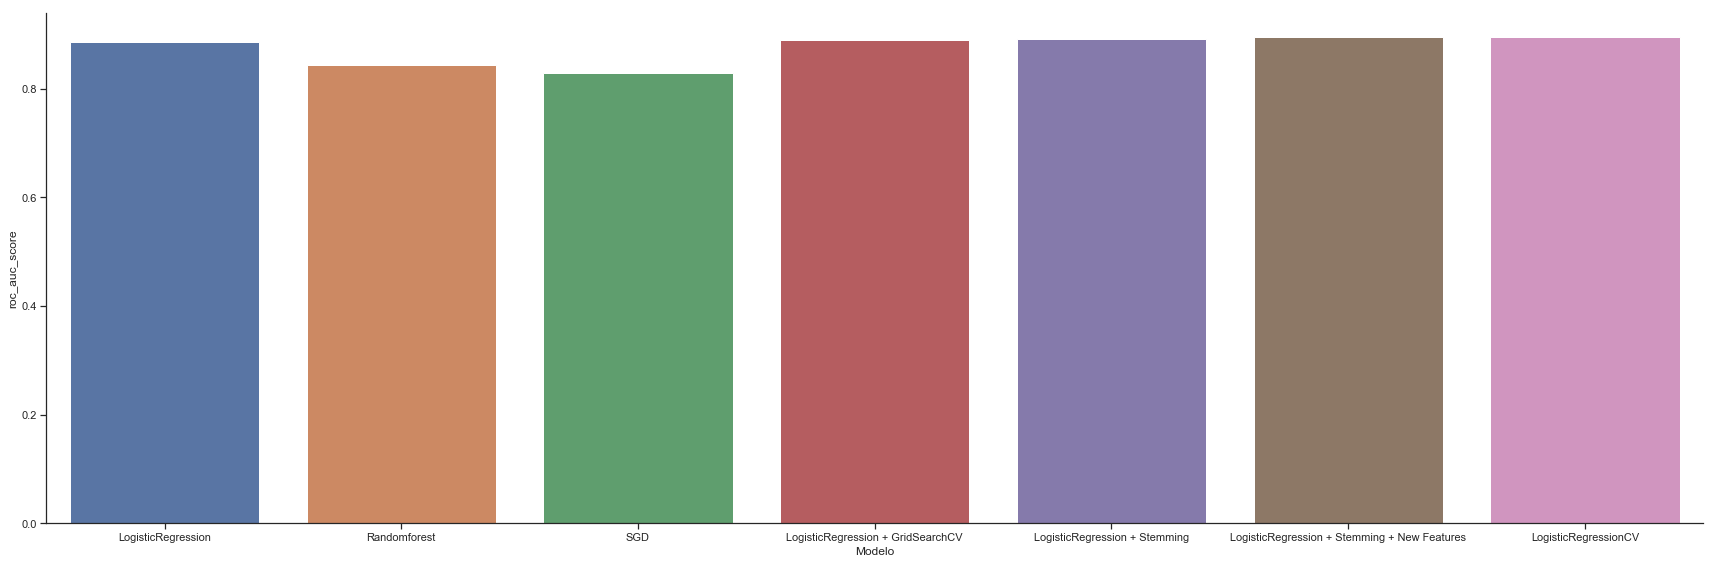

In [51]:
sns.factorplot(x= 'Modelo', y= 'roc_auc_score', data= results, kind='bar', legend='True', size=8, aspect=3)

### Modelo Final

In [2]:
dataTraining = pd.read_csv('dataTraining.csv', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('dataTesting.csv', encoding='UTF-8', index_col=0)

In [3]:
dataTraining['plot']=dataTraining['title']+[' ']+dataTraining['plot']

In [4]:
stemming =  SnowballStemmer("english")

dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: word_tokenize(x))
dataTraining['plot'] = dataTraining['plot'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

In [5]:
tf_vect = TfidfVectorizer(max_df=0.45, tokenizer=None, preprocessor=None, stop_words=None)

X_dtm = tf_vect.fit_transform(dataTraining['plot'])
X_dtm = X_dtm.toarray()

dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [6]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.21, random_state=42)

In [7]:
logreg = OneVsRestClassifier(LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_train, y_train_genres)

In [8]:
y_pred_genres = logreg.predict_proba(X_test)
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.8964232955141506

#### Multi-Label Classification Techniques:

- OneVsRest
- Binary Relevance
- Classifier Chains
- Label Powerset
- Adapted Algorithm

##### Fit con toda la data

In [25]:
logreg = OneVsRestClassifier(LogisticRegression(C=2.8988, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=-1, penalty='l2', random_state=None, solver='sag',
          tol=0.00001, verbose=0, warm_start=False),
          n_jobs=-1).fit(X_dtm, y_genres)

In [ ]:
logregcv = OneVsRestClassifier(LogisticRegressionCV(Cs=100, class_weight=None, dual=False, fit_intercept=True, cv=3,
          intercept_scaling=1, max_iter=100, multi_class='warn', scoring='roc_auc',
          n_jobs=-1, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0),
          n_jobs=-1).fit(X_dtm, y_genres)

### Metodología - Final

![Metodologia](https://github.com/amosqueraf/ML/raw/master/Metodologia_5.png)

### Evaluación sobre los datos de envío
- Carga de datos de envío para prueba

In [9]:
dataTesting['plot']=dataTesting['title']+[' ']+dataTesting['plot']

dataTesting['plot'] = dataTesting['plot'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: word_tokenize(x))
dataTesting['plot'] = dataTesting['plot'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

X_test_dtm = tf_vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

- Predicción de la probabilidad de cada genero en los datos de envío

In [10]:
y_pred_test_genres = logreg.predict_proba(X_test_dtm)

In [ ]:
y_pred_test_genres = logregcv.predict_proba(X_test_dtm)

In [11]:
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

In [14]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.072710,0.031078,0.002493,0.000706,0.245326,0.011132,0.000164,0.110972,0.002718,0.044438,...,0.010084,0.023766,0.000061,0.998366,0.000858,0.000565,0.000770,0.005726,0.000540,0.001414
4,0.028657,0.001044,0.002577,0.027837,0.314405,0.122216,0.002068,0.971421,0.001822,0.000899,...,0.002385,0.001184,0.000200,0.000622,0.000043,0.000451,0.001366,0.558873,0.001720,0.000657
5,0.003072,0.000419,0.000080,0.018148,0.005051,0.989822,0.000590,0.840017,0.000033,0.000420,...,0.001473,0.713022,0.000207,0.010893,0.025115,0.000287,0.001634,0.650039,0.002299,0.002351
6,0.013749,0.013914,0.000090,0.004595,0.010086,0.000606,0.000371,0.989721,0.001157,0.003120,...,0.002868,0.005867,0.000092,0.115615,0.040504,0.000087,0.003021,0.384416,0.018561,0.002274
7,0.000551,0.000864,0.001789,0.001179,0.120062,0.002043,0.000872,0.055176,0.004120,0.065880,...,0.001486,0.007026,0.000088,0.051372,0.604174,0.000378,0.000174,0.220753,0.000144,0.000587


In [12]:
res.to_csv('pred_genres_text_RF.csv', index_label='ID')

### Salvar el modelo
    - Se salva el modelo como .sav para usarlo en el API

In [28]:
filename = 'MoviePredictorModel.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [30]:
pickle.dump(tf_vect, open( 'tfidf_transformer.sav', "wb" ) )

### Cargar el modelo

In [0]:
model = pickle.load(open('MoviePredictorModel.sav', 'rb'))

### Crear el dash

In [ ]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

colors = {
    'background': '#111111',
    'text': '#FCF9F9'
}

app.config['suppress_callback_exceptions']=True # Sirve para evitar errores al inicio de callbacks 
                                                # que dependan de elementos no creados al momento de
                                                
app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Aplicación para el clasificación del genero de una película',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),

    html.Div(children='MIIA 4200 (2019-I): Universidad de los Andes', style={
        'textAlign': 'center',
        'color': colors['text']
    }),

    html.Div([
        html.Label('Título'),
        dcc.Input(id='title', value='Nombre Pelicula', type='text'),
                html.Div(id='div-title')
        ],style={'width': '30%', 'display': 'inline-block', 'color':'#FCF9F9'}),
     
    html.Div([
        html.Label('Año de producción'),
         #dcc.Dropdown(id='year',
          #           options=[{'label': i, 'value': i} for i in sorted(df['year'].unique())],
           #          value=2015,
            #         style={'width': '45%'}
             #       ),
         dcc.Input(id='year', value='Año', type='text'),
         html.Div(id='div-year')
        ],style={'width': '48%', 'display': 'inline-block','color':'#FCF9F9'}),

    html.Div([
        html.Label('Sinopsis'),
        dcc.Textarea(id='plot', placeholder='Ingrese la sinopsis...', value='Ingrese aquí la sinopsis de la película',
        style={'width': '50%'}),
        html.Div(id='div-plot')
        ],style={'color':'#FCF9F9'}
        ),
        
    html.Div([
           html.Label('Presione ENVIAR para cargar su información'), 
           
            html.Button('ENVIAR', id='button',style={'margin':'auto','width': "10%", 'backgroundColor': 'grey'})
    ], style={'color':'#FCF9F9'}
    ),   
   
    html.Div([
             html.Label('Según los parametros ingresados, el top 10 de la calsificación de la película son:'),
                                html.Div(id='prop_text'),
                            ], style={'marginBottom': 30, 'marginTop': 25,'fontSize': 16, 'color':'#FCF9F9'}),

    dcc.Graph(
        id='graph-probabilidad',
        figure={
            'data': [
                {'x': res['genre'].unique(), 'y': res['score'].unique(), 'type': 'bar'},
            ],
            'layout': {
                'plot_bgcolor': colors['background'],
                'paper_bgcolor': colors['background'],
                'font': {
                    'color': colors['text']
                }
            }
        }
    )
])
                                                
                                                
@app.callback(
     dash.dependencies.Output('graph-probabilidad', 'figure'),
    [dash.dependencies.Input('button', 'n_clicks')],
    [dash.dependencies.State('year', 'value'),
     dash.dependencies.State('title', 'value'),
     dash.dependencies.State('plot', 'value')
     ]
     )
def update_text(n_clicks, year, title, plot):   
     ex_dic = {
            'year':year ,
            'title':title,
            'plot': plot
            
            }

     input_df = pd.DataFrame( ex_dic, index=[1])
     
     input_df['plot_title']=input_df['title']+' '+input_df['plot']
     input_df['plot_title'] = input_df['plot_title'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
     input_df['plot_token'] = input_df['plot_title'].apply(lambda x: word_tokenize(x))
     stemming =  SnowballStemmer("english")
     input_df['plot_stemmed'] = input_df['plot_token'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))
     X_test_dtm = tfidf_transformer.transform(input_df['plot_stemmed'])
     y_pred_test_genres = MoviePredictorModel.predict_proba(X_test_dtm)
     res = pd.DataFrame(y_pred_test_genres, index=input_df.index, columns=cols)
     res=res.T.reset_index()
     res.rename(columns={'index':'genre',1:'score' },  inplace=True) 
     res.sort_values('score',ascending=False,  inplace=True)
     print(ex_dic)
     print(res)
     return {'data': [{'x': res['genre'].head(10), 'y': res['score'].head(10), 'type': 'bar'}],
             'layout': {'plot_bgcolor': colors['background'],'paper_bgcolor': colors['background'],
                'font': {'color': colors['text']}
            }
     
     }

### Correr el API

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False, host='0.0.0.0', port=8880)

### API - Movie Genre Classification

### Conectando al API
 
Go to -ec2-machine-ip-:8880

http://18.224.8.166:8880/

![Api for pricing](https://github.com/amosqueraf/ML/raw/master/console.png)

![Api for pricing](https://github.com/amosqueraf/ML/raw/master/apy_movie.png)